In [2]:
import arviz as az
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import pymc as pm
import seaborn as sns

plt.style.use("bmh")
plt.rcParams["figure.figsize"] = [12, 6]
plt.rcParams["figure.dpi"] = 100
plt.rcParams["figure.facecolor"] = "white"

%load_ext rich
%load_ext autoreload
%autoreload 2
%config InlineBackend.figure_format = "svg"

The rich extension is already loaded. To reload it, use:
  %reload_ext rich
The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [3]:
import pandas as pd
import statsmodels.api as sm


dir = "./"
cdf = pd.read_csv(dir+"data4columbia_credit.csv")
cdf.columns=['company','date','data']
cdf.date = pd.to_datetime(cdf.date)

t = (cdf["date"] - pd.Timestamp("1900-01-01")).dt.total_seconds().to_numpy()
t_min = np.min(t)
t_max = np.max(t)
t = (t - t_min) / (t_max - t_min)
cdf['t'] = t

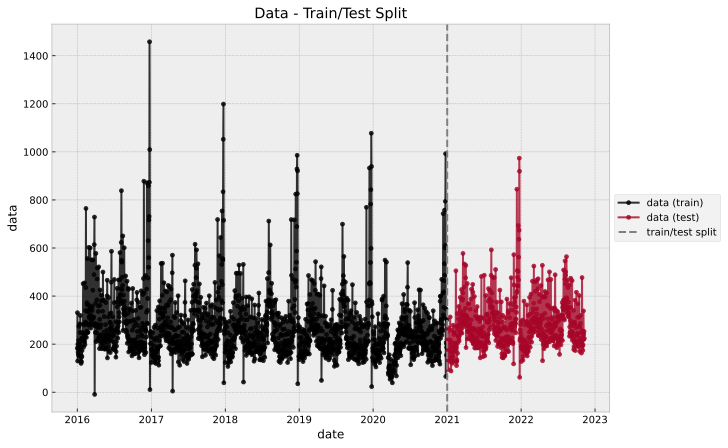

In [4]:
import datetime
import matplotlib.pyplot as plt
plt.rcParams['figure.figsize'] = (10,7)

def run_decompose(cdf, company_id, split_date):
    data = cdf[cdf.company==cdf.company.unique()[company_id]].set_index('date')
    df_train = data[data.index < split_date]
    df_test = data[data.index >= split_date]
    return df_train, df_test

train_test_date =  datetime.datetime(2021,1,1)
df_train, df_test = run_decompose(cdf, 1, train_test_date)
fig, ax = plt.subplots()
sns.lineplot(
    x="date",
    y="data",
    data=df_train,
    marker="o",
    color="black",
    alpha=0.8,
    markersize=4,
    markeredgecolor="black",
    label="data (train)",
    ax=ax,
)
sns.lineplot(
    x="date",
    y="data",
    data=df_test,
    marker="o",
    color="C1",
    alpha=0.8,
    markersize=4,
    markeredgecolor="C1",
    label="data (test)",
    ax=ax,
)
ax.axvline(x=train_test_date, color="gray", linestyle="--", label="train/test split")
ax.legend(loc="center left", bbox_to_anchor=(1, 0.5))
ax.set(title="Data - Train/Test Split");

In [6]:
x_train = df_train['t']
y_train = df_train.data

x_test = df_test['t']
y_test = df_test.data

/tmp/ipykernel_822/3073025422.py:2: DeprecationWarning: Please use `shift` from the `scipy.ndimage` namespace, the `scipy.ndimage.interpolation` namespace is deprecated.
  from scipy.ndimage.interpolation import shift
Sampling: [lag_coefs, likelihood, α, β, β_fourier_yr, σ]


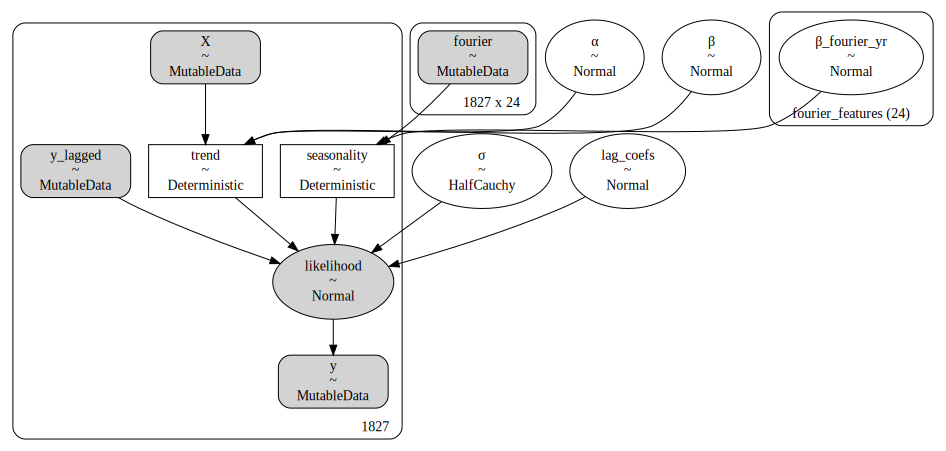

In [19]:
import numpy as np
from scipy.ndimage.interpolation import shift


"""
data ~ (α + βX) + seasonality + ar
seasonality ~ β_four * fourier_modes
"""

df_train['date'] = df_train.index
date_train = df_train["date"]
data_train = df_train["data"]

df = df_train

#fourier modes
n_order = 12
periods = df_train["date"].dt.dayofyear / 365.25
fourier_features = pd.DataFrame(
    {
        f"{func}_order_{order}": getattr(np, func)(2 * np.pi * periods * order)
        for order in range(1, n_order + 1)
        for func in ("sin", "cos")
    }
)


coords = {
    "fourier_features": np.arange(2 * n_order),
}


with pm.Model(check_bounds=False, coords=coords) as linear_with_seasonality:
    
    # data containers
    X = pm.MutableData("X", x_train)
    y = pm.MutableData("y", y_train)
    y_lagged = pm.MutableData("y_lagged", shift(y_train,1,cval=y_train.mean())) 
    
    X_four = pm.MutableData("fourier", fourier_features)
    
    α = pm.Normal("α", mu=np.mean(y_train), sigma=np.std(y_train))
    β = pm.Normal("β", mu=0, sigma=1)
    σ = pm.HalfCauchy("σ", beta=0.1)
    
    lag_coef = pm.Normal("lag_coefs", mu=0, sigma=1)
    
    β_fourier_yr = pm.Normal("β_fourier_yr", mu=0, sigma=10, dims="fourier_features")
    seasonality = pm.Deterministic(
        "seasonality", pm.math.dot(β_fourier_yr, X_four.T)
    )
    
    init = pm.Normal.dist(0, size=1)
    
    trend = pm.Deterministic("trend", α + β * X)
    ar = lag_coef * y_lagged
    
    #additive seasonality
    μ = trend + seasonality + ar
    
    pm.Normal("likelihood", mu=μ, sigma=σ, observed=y)

    linear_with_seasonality_prior_predictive = pm.sample_prior_predictive()

pm.model_to_graphviz(linear_with_seasonality)


In [11]:
linear_with_seasonality

Sampling: [lag_coefs, likelihood, α, β, β_fourier_yr, σ]


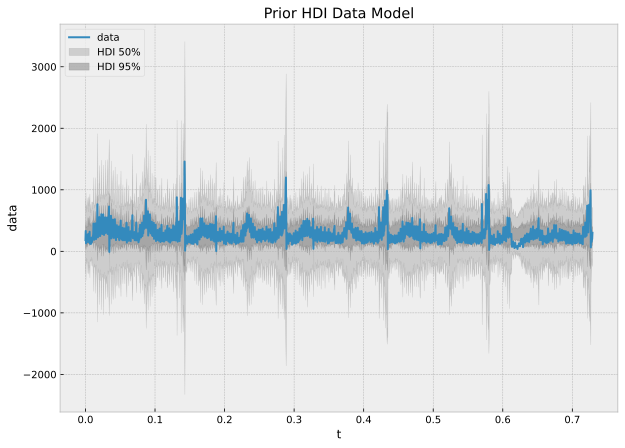

In [20]:
with linear_with_seasonality:
    temp_prior_predictive = pm.sample_prior_predictive(samples=1000)
fig, ax = plt.subplots()

sns.lineplot(
    x="t", y="data", data=df_train, color="C0", label="data", ax=ax
)
az.plot_hdi(
    x=df_train['t'],
    y=temp_prior_predictive.prior_predictive["likelihood"],
    hdi_prob=0.95,
    color="gray",
    smooth=False,
    fill_kwargs={"label": "HDI 50%", "alpha": 0.3},
    ax=ax,
)
az.plot_hdi(
    x=df_train['t'],
    y=temp_prior_predictive.prior_predictive["likelihood"],
    hdi_prob=0.5,
    color="gray",
    smooth=False,
    fill_kwargs={"label": "HDI 95%", "alpha": 0.5},
    ax=ax,
)
ax.legend(loc="upper left")
ax.set(title="Prior HDI Data Model");

In [21]:
with linear_with_seasonality:
    temp_idata = pm.sample(
        target_accept=0.9, draws=4000, chains=4
    )
    temp_posterior_predictive = pm.sample_posterior_predictive(trace=temp_idata)
    
az.summary(data=temp_idata)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [α, β, σ, lag_coefs, β_fourier_yr]


100.00% [20000/20000 05:49<00:00 Sampling 4 chains, 0 divergences]

Sampling 4 chains for 1_000 tune and 4_000 draw iterations (4_000 + 16_000 draws total) took 350 seconds.
Chain <xarray.DataArray 'chain' ()>
array(0)
Coordinates:
    chain    int64 0 reached the maximum tree depth. Increase `max_treedepth`, increase `target_accept` or reparameterize.
Chain <xarray.DataArray 'chain' ()>
array(1)
Coordinates:
    chain    int64 1 reached the maximum tree depth. Increase `max_treedepth`, increase `target_accept` or reparameterize.
Chain <xarray.DataArray 'chain' ()>
array(2)
Coordinates:
    chain    int64 2 reached the maximum tree depth. Increase `max_treedepth`, increase `target_accept` or reparameterize.
Chain <xarray.DataArray 'chain' ()>
array(3)
Coordinates:
    chain    int64 3 reached the maximum tree depth. Increase `max_treedepth`, increase `target_accept` or reparameterize.
Sampling: [likelihood]


100.00% [16000/16000 00:02<00:00]

mean 
 sd 
 hdi_3% 
 hdi_97% 
 mcse_mean 
 mcse_sd 
 ess_bulk 
 ess_tail 
 r_hat 
 
 
 
 
 α 
 160.494 
 6.230 
 148.593 
 171.925 
 0.049 
 0.034 
 16367.0 
 13088.0 
 1.0 
 
 
 β 
 -0.521 
 1.006 
 -2.452 
 1.302 
 0.005 
 0.008 
 34862.0 
 11367.0 
 1.0 
 
 
 lag_coefs 
 0.400 
 0.022 
 0.360 
 0.440 
 0.000 
 0.000 
 16021.0 
 13172.0 
 1.0 
 
 
 β_fourier_yr[0] 
 -4.261 
 3.189 
 -10.359 
 1.563 
 0.017 
 0.017 
 37367.0 
 11130.0 
 1.0 
 
 
 β_fourier_yr[1] 
 7.914 
 3.144 
 2.001 
 13.773 
 0.017 
 0.014 
 34573.0 
 10599.0 
 1.0 
 
 
 ... 
 ... 
 ... 
 ... 
 ... 
 ... 
 ... 
 ... 
 ... 
 ... 
 
 
 trend[1822] 
 160.116 
 6.224 
 148.394 
 171.627 
 0.048 
 0.034 
 16547.0 
 13195.0 
 1.0 
 
 
 trend[1823] 
 160.115 
 6.224 
 148.393 
 171.628 
 0.048 
 0.034 
 16548.0 
 13195.0 
 1.0 
 
 
 trend[1824] 
 160.115 
 6.224 
 148.392 
 171.626 
 0.048 
 0.034 
 16548.0 
 13195.0 
 1.0 
 
 
 trend[1825] 
 160.115 
 6.224 
 148.392 
 171.626 
 0.048 
 0.034 
 16548.0 
 13195.0 
 1.0 
 
 
 trend[1826] 
 160.115 
 6.224 
 148.391 
 171.626 
 0.048 
 0.034 
 16549.0 
 13195.0 
 1.0 
 
 
 
 3682 rows × 9 columns

In [27]:
az.plot_trace(
    data=temp_idata,
    compact=True,
    var_names=["β_fourier_yr",'α','β','lag_coefs','σ'],
    kind="rank_bars",
    backend_kwargs={"figsize": (12, 9), "layout": "constrained"},
)

array([[<AxesSubplot: title={'center': 'β_fourier_yr'}>,
        <AxesSubplot: title={'center': 'β_fourier_yr'}, xlabel='Rank (all chains)', ylabel='Chain'>],
       [<AxesSubplot: title={'center': 'α'}>,
        <AxesSubplot: title={'center': 'α'}, xlabel='Rank (all chains)', ylabel='Chain'>],
       [<AxesSubplot: title={'center': 'β'}>,
        <AxesSubplot: title={'center': 'β'}, xlabel='Rank (all chains)', ylabel='Chain'>],
       [<AxesSubplot: title={'center': 'lag_coefs'}>,
        <AxesSubplot: title={'center': 'lag_coefs'}, xlabel='Rank (all chains)', ylabel='Chain'>],
       [<AxesSubplot: title={'center': 'σ'}>,
        <AxesSubplot: title={'center': 'σ'}, xlabel='Rank (all chains)', ylabel='Chain'>]],
      dtype=object)

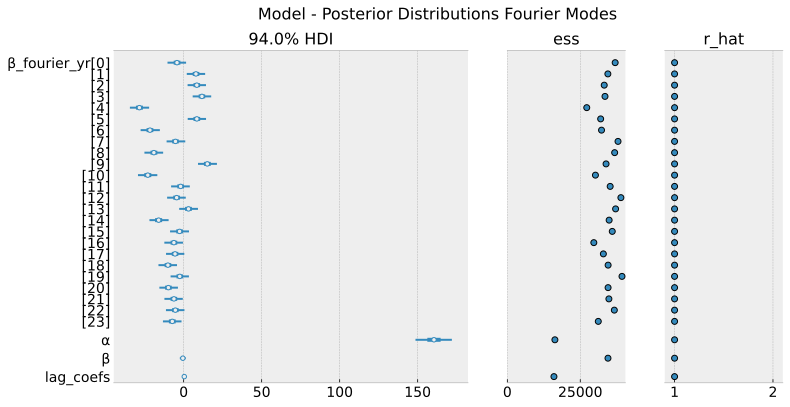

In [23]:
ax = az.plot_forest(
    kind="forestplot",
    data=temp_idata,
    var_names=["β_fourier_yr",'α','β','lag_coefs'],
    combined=True,
    r_hat=True,
    ess=True,
    figsize=(12, 6),
)
plt.gcf().suptitle(
    "Model - Posterior Distributions Fourier Modes", fontsize=16
);

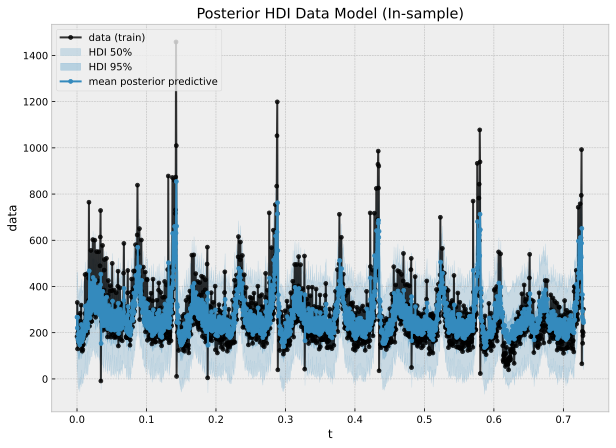

In [24]:
fig, ax = plt.subplots()

sns.lineplot(
    x="t",
    y="data",
    data=df_train,
    marker="o",
    color="black",
    alpha=0.8,
    markersize=4,
    markeredgecolor="black",
    label="data (train)",
)
az.plot_hdi(
    x=df_train['t'],
    y=temp_posterior_predictive.posterior_predictive["likelihood"],
    hdi_prob=0.95,
    color="C0",
    smooth=False,
    fill_kwargs={"label": "HDI 50%", "alpha": 0.2},
    ax=ax,
)
az.plot_hdi(
    x=df_train['t'],
    y=temp_posterior_predictive.posterior_predictive["likelihood"],
    hdi_prob=0.5,
    color="C0",
    smooth=False,
    fill_kwargs={"label": "HDI 95%", "alpha": 0.3},
    ax=ax,
)
sns.lineplot(
    x=df_train['t'],
    y=temp_posterior_predictive.posterior_predictive["likelihood"]
    .stack(samples=("chain", "draw"))
    .mean(axis=1),
    marker="o",
    color="C0",
    markersize=4,
    markeredgecolor="C0",
    label="mean posterior predictive",
    ax=ax,
)
ax.legend(loc="upper left")
ax.set(title="Posterior HDI Data Model (In-sample)");

In [25]:
# Update data reference.

#fourier
n_order = 12
df_test['date'] = df_test.index
periods = df_test["date"].dt.dayofyear / 365.25
fourier_features_test = pd.DataFrame(
    {
        f"{func}_order_{order}": getattr(np, func)(2 * np.pi * periods * order)
        for order in range(1, n_order + 1)
        for func in ("sin", "cos")
    }
)

with linear_with_seasonality:
    pm.set_data({"X": x_test, 'y':y_test, 'fourier' : fourier_features_test, 'y_lagged': shift(y_test,1)})
    ppc_test = pm.sample_posterior_predictive(temp_idata, model=linear_with_seasonality)
ppc_test

Sampling: [likelihood]


100.00% [16000/16000 00:05<00:00]

arviz.InferenceData 
 
 
 
 
 
 posterior_predictive 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 <xarray.Dataset>
Dimensions: (chain: 4, draw: 4000, likelihood_dim_2: 678)
Coordinates:
 * chain (chain) int64 0 1 2 3
 * draw (draw) int64 0 1 2 3 4 5 ... 3994 3995 3996 3997 3998 3999
 * likelihood_dim_2 (likelihood_dim_2) int64 0 1 2 3 4 ... 673 674 675 676 677
Data variables:
 likelihood (chain, draw, likelihood_dim_2) float64 -16.19 ... 32.23
Attributes:
 created_at: 2023-03-09T00:47:37.541754
 arviz_version: 0.15.1
 inference_library: pymc
 inference_library_version: 5.1.1 xarray.Dataset Dimensions: chain : 4 draw : 4000 likelihood_dim_2 : 678 Coordinates: (3) chain (chain) int64 0 1 2 3 array([0, 1, 2, 3]) draw (draw) int64 0 1 2 3 4 ... 3996 3997 3998 3999 array([ 0, 1, 2, ..., 3997, 3998, 3999]) likelihood_dim_2 (likelihood_dim_2) int64 0 1 2 3 4 5 ... 673 674 675 676 677 array([ 0, 1, 2, ..., 675, 676, 677]) Data variables: (1) likelihood (chain, draw, likelihood_dim_2) float64 -16.19 77.47 304.4 ... 112.4 32.23 array([[[-16.18673419, 77.47461972, 304.35220963, ..., 77.46890485,
 407.88862598, 222.85816343],
 [110.27870954, 472.47465866, 217.61715541, ..., 98.68824432,
 81.56551844, 147.42503881],
 [102.9660206 , 210.93080578, 149.69233407, ..., 107.9680704 ,
 324.7013218 , 264.38877779],
 ...,
 [234.61898236, 74.57944944, 206.36505835, ..., 40.6850438 ,
 149.68360956, 66.73669023],
 [179.41117467, -18.67147861, 183.59986625, ..., 283.00633561,
 437.4033085 , 210.96883934],
 [ 54.17573202, 369.89434767, 93.06535339, ..., 204.55172262,
 245.69383297, 330.78092446]],

 [[235.64164467, 217.76031288, 163.75235419, ..., 332.22183411,
 314.94078888, 165.2087322 ],
 [229.7574116 , 221.23398059, 140.8678899 , ..., 431.63814951,
 149.85593881, 222.99960529],
 [327.94357603, 210.80040996, 228.22168968, ..., 208.59079611,
 365.99059123, 366.44798298],
...
 [ 94.94855213, 253.83330417, 177.21338771, ..., 232.06019682,
 336.05045177, 300.25548551],
 [ 35.16194411, 198.5354522 , 352.77736764, ..., 206.85774051,
 194.2365111 , 127.74856805],
 [232.29615017, 405.00742529, 151.45009242, ..., 336.28046554,
 175.28422072, 289.09886702]],

 [[247.12032266, 197.87929767, 135.22230599, ..., 259.95869087,
 249.27264925, 356.60543 ],
 [339.02578875, 209.26795953, 78.92399121, ..., 277.86649963,
 152.80675794, 304.70420198],
 [ 79.22985989, 175.7524151 , 235.58123784, ..., 339.69022004,
 121.80758235, 347.45601518],
 ...,
 [153.41600951, 104.55700855, 130.07910831, ..., 256.47777307,
 78.69927631, 390.71140716],
 [293.9447015 , 311.51157514, 366.10758989, ..., 180.41936362,
 119.89511247, 338.30359266],
 [204.09569667, 220.69481895, 72.73774542, ..., 330.86522051,
 112.39247355, 32.23348713]]]) Indexes: (3) chain PandasIndex PandasIndex(Int64Index([0, 1, 2, 3], dtype='int64', name='chain')) draw PandasIndex PandasIndex(Int64Index([ 0, 1, 2, 3, 4, 5, 6, 7, 8, 9,
 ...
 3990, 3991, 3992, 3993, 3994, 3995, 3996, 3997, 3998, 3999],
 dtype='int64', name='draw', length=4000)) likelihood_dim_2 PandasIndex PandasIndex(Int64Index([ 0, 1, 2, 3, 4, 5, 6, 7, 8, 9,
 ...
 668, 669, 670, 671, 672, 673, 674, 675, 676, 677],
 dtype='int64', name='likelihood_dim_2', length=678)) Attributes: (4) created_at : 2023-03-09T00:47:37.541754 arviz_version : 0.15.1 inference_library : pymc inference_library_version : 5.1.1 
 
 
 
 
 
 
 observed_data 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 <xarray.Dataset>
Dimensions: (likelihood_dim_0: 678)
Coordinates:
 * likelihood_dim_0 (likelihood_dim_0) int64 0 1 2 3 4 ... 673 674 675 676 677
Data variables:
 likelihood (likelihood_dim_0) float64 218.8 251.8 ... 253.4 224.1
Attributes:
 created_at: 2023-03-09T00:47:37.543586
 arviz_version: 0.15.1
 inference_library: pymc
 inference_library_version: 5.1.1 xarray.Dataset Dimensions: likelihood_dim_0 : 678 Coordinates: (1) likelihood_dim_0 (likelihood_dim_0) int64 0 1 2 3 4 5 ... 673 674 675 676 677 array([ 0, 1, 2, ..., 675, 676, 677]) Data variables: (1) likelihood (likelihood_dim_0) float64 

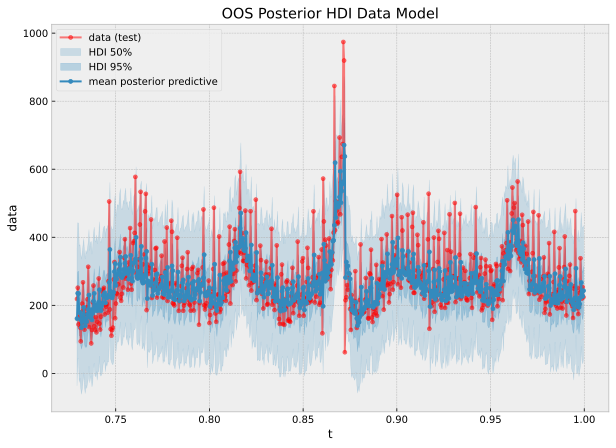

In [26]:
fig, ax = plt.subplots()

sns.lineplot(
    x="t",
    y="data",
    data=df_test,
    marker="o",
    color="red",
    alpha=0.5,
    markersize=4,
    markeredgecolor="red",
    label="data (test)",
)
az.plot_hdi(
    x=df_test['t'],
    y=ppc_test.posterior_predictive["likelihood"],
    hdi_prob=0.95,
    color="C0",
    smooth=False,
    fill_kwargs={"label": "HDI 50%", "alpha": 0.2},
    ax=ax,
)
az.plot_hdi(
    x=df_test['t'],
    y=ppc_test.posterior_predictive["likelihood"],
    hdi_prob=0.5,
    color="C0",
    smooth=False,
    fill_kwargs={"label": "HDI 95%", "alpha": 0.3},
    ax=ax,
)
sns.lineplot(
    x=df_test['t'],
    y=ppc_test.posterior_predictive["likelihood"]
    .stack(samples=("chain", "draw"))
    .mean(axis=1),
    marker="o",
    color="C0",
    markersize=4,
    markeredgecolor="C0",
    label="mean posterior predictive",
    ax=ax,
)
ax.legend(loc="upper left")
ax.set(title="OOS Posterior HDI Data Model");